In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import beta
from scipy.stats import gamma
import matplotlib.pyplot as plt

from utils.visualisations import plot_reliability_diagram

from sklearn.utils import column_or_1d

from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize_scalar

plt.rcParams['figure.figsize'] = (10, 4)

linspace = np.linspace(0.01, 0.99, 50)

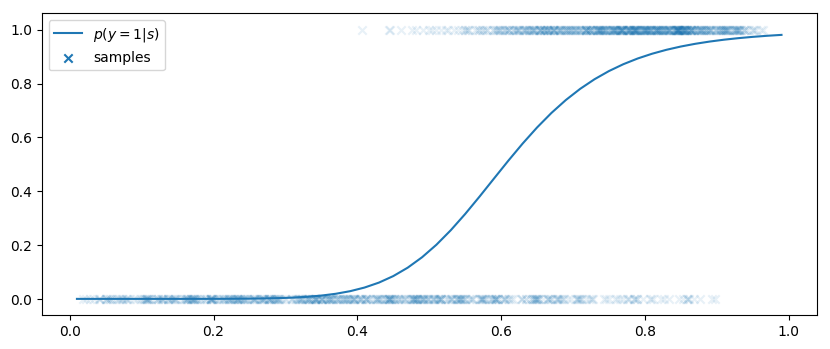

In [2]:
n_samples = 1000
prior0 = 0.5
prior1 = 1-prior0
a0 = 2.0
b0 = 3.0
a1 = 10.0
b1 = 3.0
pos_x = np.random.beta(a0, b0, int(n_samples*prior0))
neg_x = np.random.beta(a1, b1, int(n_samples*prior1))

scores = np.hstack((pos_x, neg_x))
labels = np.hstack((np.zeros(int(n_samples*prior0)), np.ones(int(n_samples*prior1))))

plt.scatter(scores, labels, marker='x', alpha=0.1, label='samples')
plt.plot(linspace, beta.pdf(linspace, a1, b1)/(beta.pdf(linspace, a0, b0) + beta.pdf(linspace, a1, b1)),
         label='$p(y=1|s)$')
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# $BetaCal(a,b,m)$

Estimated values :	 a = 9.19, b = -0.49, m = 0.61


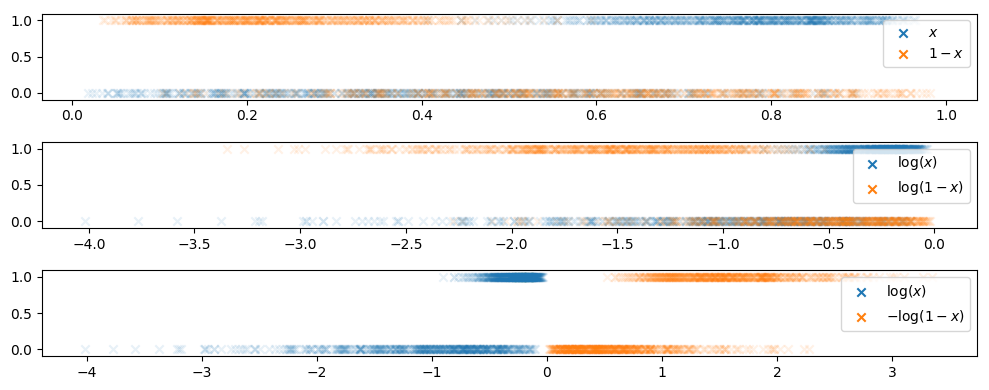

In [3]:
fig = plt.figure()

x = scores.reshape(-1, 1)

eps = np.finfo(x.dtype).eps
x = np.clip(x, eps, 1-eps)
x = np.hstack((x, 1. - x))
ax = fig.add_subplot(311)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$x$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$1-x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(x)
ax = fig.add_subplot(312)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$\log(1-x)$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x[:, 1] *= -1
ax = fig.add_subplot(313)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$-\log(1-x)$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

plt.tight_layout()

lr = LogisticRegression(C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
inter = lr.intercept_
a = coefs[0]
b = coefs[1]

m = minimize_scalar(lambda mh: np.abs(b*np.log(1.-mh)-a*np.log(mh)-inter),
                    bounds=[0, 1], method='Bounded').x[0]

print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

# $BetaCal(a, b, m|m=0.5)$

Estimated values :	 a = 6.03, b = -0.71, m = 0.50


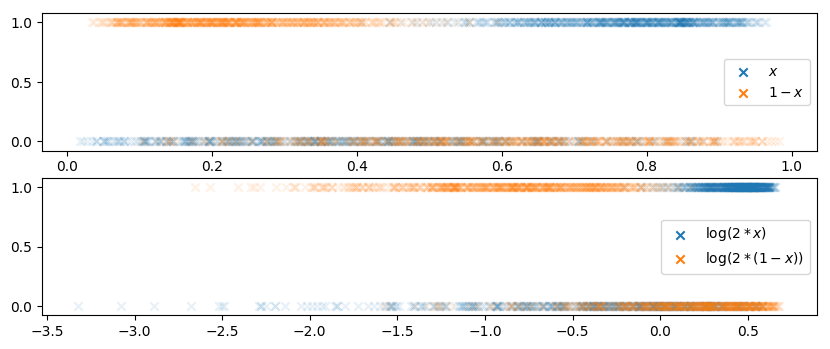

In [4]:
fig = plt.figure()

x = scores.reshape(-1, 1)
x = np.clip(x, eps, 1-eps)

x = np.hstack((x, 1. - x))
ax = fig.add_subplot(211)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$x$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$1-x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(2 * x)
ax = fig.add_subplot(212)
ax.scatter(x[:,0], labels, marker='x', alpha=0.1, label='$\log(2*x)$')
ax.scatter(x[:,1], labels, marker='x', alpha=0.1, label='$\log(2*(1-x))$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

lr = LogisticRegression(fit_intercept=False, C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
a = coefs[0]
b = -coefs[1]
m = 0.5

print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

# $BetaCal(a,b,m|a=b)$

Estimated values :	 a = 2.73, b = 2.73, m = 0.63


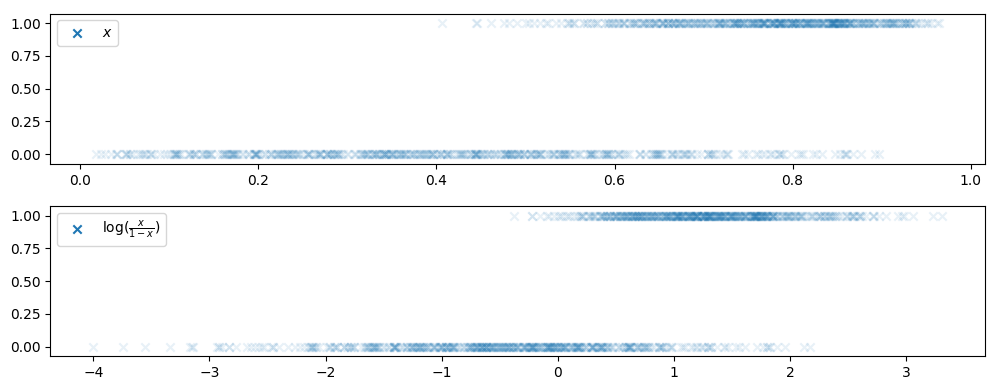

In [5]:
fig = plt.figure()

x = scores.reshape(-1, 1)
x = np.clip(x, eps, 1-eps)
ax = fig.add_subplot(211)
ax.scatter(x, labels, marker='x', alpha=0.1, label='$x$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

x = np.log(x / (1. - x))
ax = fig.add_subplot(212)
ax.scatter(x, labels, marker='x', alpha=0.1, label=r'$\log(\frac{x}{1-x})$')
ax.legend()
for lh in ax.legend_.legendHandles:
    lh.set_alpha(1)

plt.tight_layout()

lr = LogisticRegression(C=99999999999)
lr.fit(x, labels)
coefs = lr.coef_[0]
inter = lr.intercept_[0]
a = coefs[0]
b = a
m = 1.0 / (1.0 + np.exp(inter / a))

print('Estimated values :\t a = {:0.2f}, b = {:0.2f}, m = {:0.2f}'.format(a,b,m))

In [6]:
def BetaConst(a, b):
    return gamma(a+b)/(gamma(a)*gamma(b))